# Assignment 6: CudaVision
------
### Group Members:
__1.__ Saikat Roy

__2.__ Albert Gubaidullin

__Please note that detailed architectures and results are available in the output with *readable* messages. Important things are summarized either in the Headings or in the text block below the heading.__

## Import Dependencies
------

In [0]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
from torchvision import datasets, transforms
from torchsummary import summary

import zipfile
from PIL import Image

import matplotlib.pyplot as plt

import time
import os

from sklearn import linear_model

# from google.colab import drive
# drive.mount('/content/drive')

## Encoder object definition and loading
------
A pretrained resnet18 object is loaded from `torchvision.models`, moved to the GPU and summarized.

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
#         out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda()

## Decoder object definition and loading
------
A pretrained resnet18 object is loaded from `torchvision.models`, moved to the GPU and summarized.

In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        #out = x.view(batch_size,256,7,7)
        out = self.layer1(x)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

##CAE (X)

In [0]:
class CAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(CAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        return x

## Intializing CIFAR-10 datasets and some Hyperparameters
---------


In [4]:
batch_size = 32
n_itr = 25
lr = 0.001

transform_list = transforms.Compose([transforms.Resize(64),
                                     transforms.ToTensor()])
trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transform_list)
testset = datasets.CIFAR10('./data', train=False, download=True, transform=transform_list)

train_dataloader  = torch.utils.data.DataLoader(trainset,  batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader  = torch.utils.data.DataLoader(testset,  batch_size=batch_size, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# train_split, valid_split = random_split(trainset, [ int(len(trainset)*0.8), 
#                                         int(len(trainset)-(len(trainset)*0.8))])
# train_dataloader = torch.utils.data.DataLoader(train_split, batch_size=batch_size,
#                                                shuffle=True, drop_last=True)
# valid_dataloader = torch.utils.data.DataLoader(valid_split, batch_size=batch_size,
#                                                shuffle=True, drop_last=True)

In [5]:
# Check output of autoencoder

for image,label in train_dataloader:
    image = image.cuda()
    
    output = encoder(image)
    output = decoder(output)
    print(output.size())
    break

torch.Size([32, 3, 64, 64])


## Method for calculating accuracy (X)
------
The `acc` method simply calculates the predictive accuracy of a model on the given dataloader. It returns the true labels, predicted labels and the accuracy as a float in the range [0,1]

In [0]:
def acc(dataloader):
    """
    Calculate accuracy of predictions from model for dataloader.
    :param dataloader: dataloader to evaluate
    :return:
    """
    acc = 0.0
    true_y = []
    pred_y = []
    total = 0.0
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for batch_id, (x, y) in enumerate(dataloader):
            x = x.cuda()
            y = y.cuda()
            #x = x.view(batch_size, -1)
            # print(x[0])
            preds = model(x)
            preds = torch.argmax(preds, dim=1)
            acc += ((preds==y).sum().item())
            total+= y.size(0)

            true_y.extend(list(preds.view(-1).cpu().numpy()))
            pred_y.extend(list(y.view(-1).cpu().numpy()))

        acc/=total
    return true_y, pred_y, acc

##Image Show

In [0]:
def imgs_show(img1, img2): 
  # check image with noise and denoised image\n# Better image if you train more or upgrade the model\n
  img1 = img1.cpu().detach().numpy()
  img2 = img2.cpu().detach().numpy()
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(img1)
  ax2.imshow(img2)
  plt.show()

#CAE

## Method for training CAE model in PyTorch
------

In [0]:
def train(train_dataloader, valid_dataloader, encoder, decoder, iters = 20, suppress_output=False,
         model_save_path = "best.pth"):
    """
    Trains the model on the given dataloader and returns the loss per epoch
    """
    loss_l = []
    train_acc_l = []
    valid_acc_l = []
    best_valid_acc = 0.0
    equiv_train_acc = 0.0
    for itr in range(iters):
        av_itr_loss = 0.0
        encoder.train()
        decoder.train()
        for batch_id, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            x = x.cuda()
            enc_out = encoder(x)
            dec_out = decoder(enc_out)
            # print((z==1).sum())
            batch_loss = loss(dec_out, x)
            batch_loss.backward()
            optimizer.step()
            av_itr_loss += (1/y.size(0))*batch_loss.item() #??
        
        loss_l.append(av_itr_loss)
#         _, _, train_acc = acc(train_dataloader)
#         _, _, valid_acc = acc(valid_dataloader)
        
        if not suppress_output:
          if itr%1 == 0 or itr==iters-1:
            print("Epoch {}: Loss={}"
                  .format(itr, av_itr_loss))
#         train_acc_l.append(train_acc)
#         valid_acc_l.append(valid_acc)
#         if valid_acc>best_valid_acc:
#           best_valid_acc = valid_acc
#           equiv_train_acc = train_acc
        torch.save(encoder.state_dict(), model_save_path + "\encoder")
        torch.save(decoder.state_dict(), model_save_path + "\decoder")
        imgs_show(x[0][0],dec_out[0][0])
       
#     encoder.load_state_dict(torch.load(model_save_path+ "\encoder"))
#     decoder.load_state_dict(torch.load(model_save_path+ "\decoder"))
    
#   return loss_l, train_acc_l, valid_acc_l
    return loss_l #, equiv_train_acc, best_valid_acc


## Training the CAE model
------



Epoch 0: Loss=0.38570054586671176


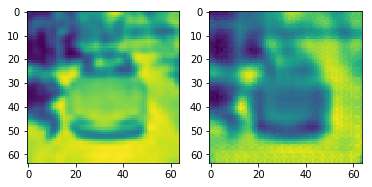

Epoch 1: Loss=0.1455852075414441


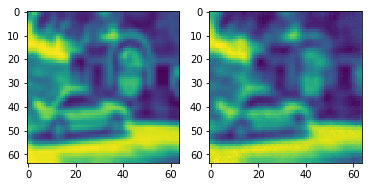

Epoch 2: Loss=0.10389336821026518


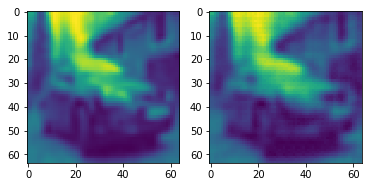

KeyboardInterrupt: ignored

In [0]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
optim = torch.optim.Adam

t1 = time.time()
#model.fc = nn.Linear(512, no_of_classes) # Redefining output layer for binary problem ??
#model = CAE(encoder, decoder)
#model.cuda()

#model.train()
# The CE Loss is weighed with the amount of positive and negative classes
# since the dataset is not balanced
loss = nn.MSELoss()
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim(parameters, lr=lr)
loss_list = train(train_dataloader, test_dataloader, 
                                        encoder, 
                                        decoder,
                                        iters=n_itr, 
                                        model_save_path="model1.pth")
t2 = time.time()

#_,_, test_acc = acc(valid_dataloader)
print("Time to converge: {} sec".format(t2-t1))
# print("Best train accuracy={}, valid accuracy={} (based on the later)".
#                                           format(train_acc, valid_acc))
# print("Test accuracy on best model={}".format(test_acc))

#DCAE

##Noise adding function

In [0]:
def noise_add(image, prob=0.1):
  image_n = torch.mul(image+0.25, prob * torch.rand(1,1,64,64))
  image_n = image_n.cuda()
  return image_n

## Method for training DCAE model in PyTorch
------

In [0]:
def train(train_dataloader, valid_dataloader, encoder, decoder, noise, iters = 20, suppress_output=False,
         model_save_path = "best.pth"):
    """
    Trains the model on the given dataloader and returns the loss per epoch
    """
    loss_l = []
    train_acc_l = []
    valid_acc_l = []
    best_valid_acc = 0.0
    equiv_train_acc = 0.0
    for itr in range(iters):
        av_itr_loss = 0.0
        encoder.train()
        decoder.train()
        for batch_id, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
#             if batch_id %10 == 0:
#               imgs_show(x[0][0],noise_add(x, noise)[0][0])
            x = noise_add(x, noise)
            x = x.cuda()
            enc_out = encoder(x)
            dec_out = decoder(enc_out)
            # print((z==1).sum())
            batch_loss = loss(dec_out, x)
            batch_loss.backward()
            optimizer.step()
            av_itr_loss += (1/y.size(0))*batch_loss.item() #??
        
        loss_l.append(av_itr_loss)
#         _, _, train_acc = acc(train_dataloader)
#         _, _, valid_acc = acc(valid_dataloader)
        
        if not suppress_output:
          if itr%1 == 0 or itr==iters-1:
            print("Epoch {}: Loss={}"
                  .format(itr, av_itr_loss))
#         train_acc_l.append(train_acc)
#         valid_acc_l.append(valid_acc)
#         if valid_acc>best_valid_acc:
#           best_valid_acc = valid_acc
#           equiv_train_acc = train_acc
        torch.save(encoder.state_dict(), model_save_path + "\encoder")
        torch.save(decoder.state_dict(), model_save_path + "\decoder")
        #print(x[0][0])
        #print(dec_out[0][0])
        imgs_show(x[0][0],dec_out[0][0])
    
#     encoder.load_state_dict(torch.load(model_save_path+ "\encoder"))
#     decoder.load_state_dict(torch.load(model_save_path+ "\decoder"))
    
#   return loss_l, train_acc_l, valid_acc_l
    return loss_l #, equiv_train_acc, best_valid_acc


## Training the DCAE model
------



Epoch 0: Loss=0.21366280766827117


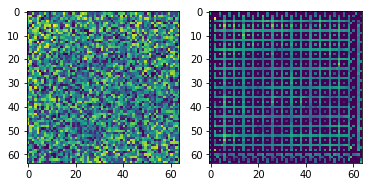

Epoch 1: Loss=0.0006008917236783873


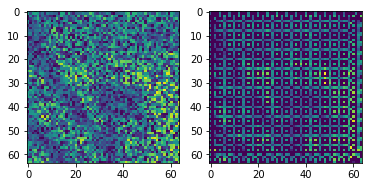

Epoch 2: Loss=0.0006017388968189152


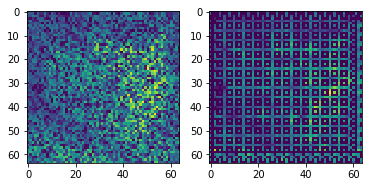

Epoch 3: Loss=0.0006119040678527199


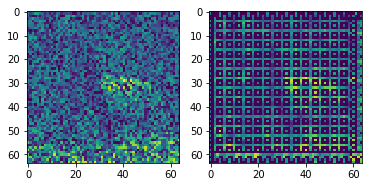

Epoch 4: Loss=0.0005945451783020417


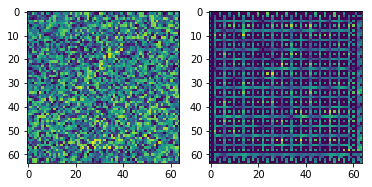

Epoch 5: Loss=0.0005978671546245096


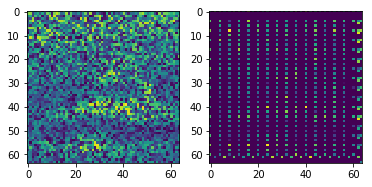

Epoch 6: Loss=0.0007800967494233646


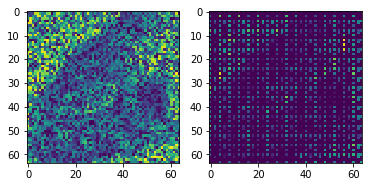

Epoch 7: Loss=0.0007622924784413954


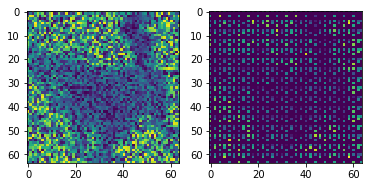

Epoch 8: Loss=0.0007507791542025188


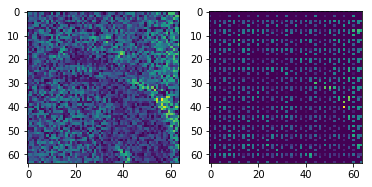

Epoch 9: Loss=0.0007415763231790606


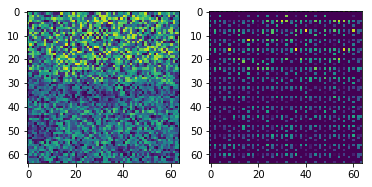

Epoch 10: Loss=0.0007711199743027919


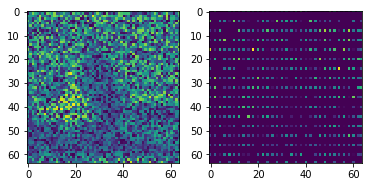

Epoch 11: Loss=0.0007736581592610037


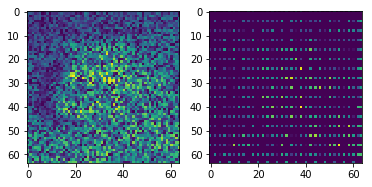

Epoch 12: Loss=0.0007709010472751743


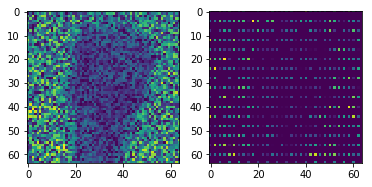

Epoch 13: Loss=0.0007697744657946259


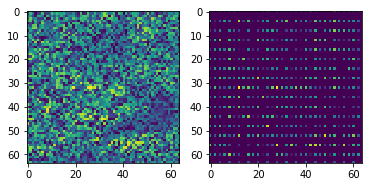

Epoch 14: Loss=0.000765860228824522


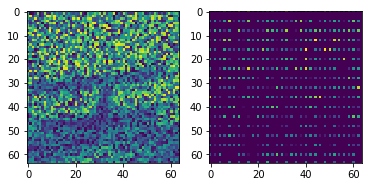

Epoch 15: Loss=0.0007510044269167793


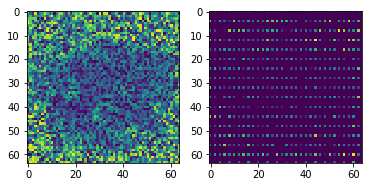

In [0]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
optim = torch.optim.Adam

t1 = time.time()
#model.fc = nn.Linear(512, no_of_classes) # Redefining output layer for binary problem ??
#model = CAE(encoder, decoder)
#model.cuda()

#model.train()
# The CE Loss is weighed with the amount of positive and negative classes
# since the dataset is not balanced
loss = nn.MSELoss()
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim(parameters, lr=lr)
loss_list = train(train_dataloader, test_dataloader, 
                                        encoder, 
                                        decoder,
                                        noise = 0.01,
                                        iters=n_itr, 
                                        model_save_path="model1.pth")
t2 = time.time()

#_,_, test_acc = acc(valid_dataloader)
print("Time to converge: {} sec".format(t2-t1))
# print("Best train accuracy={}, valid accuracy={} (based on the later)".
#                                           format(train_acc, valid_acc))
# print("Test accuracy on best model={}".format(test_acc))

# Latent space for CIFAR10 header

## Method for training model in PyTorch
------
The `train` method takes a dataloader object and trains the model on it for the specified amount of iterations and returns the loss per iteration as a list.

In [0]:
def train_latent(train_dataloader, valid_dataloader, iters = 20, suppress_output=False,
         model_save_path = "best_enc.pth"):
    """
    Trains the model on the given dataloader and returns the loss per epoch
    """
    loss_l = []
    for itr in range(iters):
        av_itr_loss = 0.0
        encoder.train()
        decoder.train()
        for batch_id, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            x = x.cuda()
            enc_out = encoder(x)
            dec_out = decoder(enc_out)
            # print((z==1).sum())
            batch_loss = loss(dec_out, x)
            batch_loss.backward()
            optimizer.step()
            av_itr_loss += (1/y.size(0))*batch_loss.item()
        
        loss_l.append(av_itr_loss)
        if not suppress_output:
          if itr%1 == 0 or itr==iters-1:
            print("Epoch {}: Loss={}".format(itr, av_itr_loss))
        imgs_show(x[0][0],dec_out[0][0])
        
#   return loss_l, train_acc_l, valid_acc_l
    return loss_l

## Training the model on CIFAR 10 for Classification on Latent Space
------
Due to the dimensionality of the latent space, only 5024 images from train and test dataset have been used for classification here. The code establishes how to use the latent space of of CAE for this classification task. A Linear SVM has been used as a classifier.

Epoch 0: Loss=1.3089659441029653


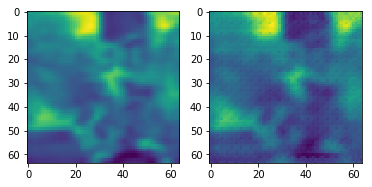

Epoch 1: Loss=0.6638628070941195


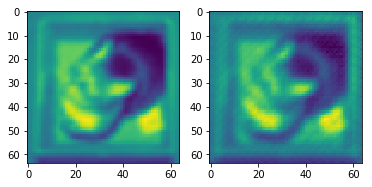

Epoch 2: Loss=0.4637753629795043


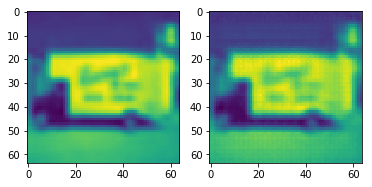

Epoch 3: Loss=0.3565229904343141


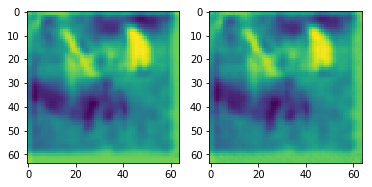

Epoch 4: Loss=0.3529493676032871


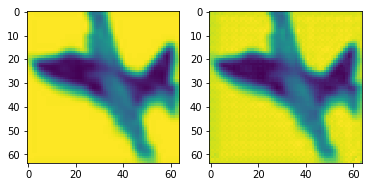

Time to converge: 570.7847945690155 sec


In [8]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
optim = torch.optim.Adam

t1 = time.time()
#model.fc = nn.Linear(512, no_of_classes) # Redefining output layer for binary problem ??
#model = CAE(encoder, decoder)
#model.cuda()

#model.train()
# The CE Loss is weighed with the amount of positive and negative classes
# since the dataset is not balanced
loss = nn.MSELoss()
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim(parameters, lr=lr)
loss_list = train_latent(train_dataloader, test_dataloader, 
                                        iters=5, 
                                        model_save_path="model_lsp.pth")
t2 = time.time()

#_,_, test_acc = acc(valid_dataloader)
print("Time to converge: {} sec".format(t2-t1))
# print("Best train accuracy={}, valid accuracy={} (based on the later)".
#                                           format(train_acc, valid_acc))
# print("Test accuracy on best model={}".format(test_acc)

In [13]:
encoder.eval()

def create_dataset_latent(dataloader):
    data = None
    y_np = None

    for batch_id, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        x = x.cuda()
        enc_out = encoder(x).detach().view(x.size(0),-1)
        if data is None:
          data = enc_out.cpu().numpy()
          y_np = y.detach().cpu().numpy()
        else:
          data = np.append(data, enc_out.cpu().numpy(), 0)
          y_np = np.append(y_np, y.detach().cpu().numpy(), 0)
          if y_np.shape[0]>=5000:
            break
    
    return data, y_np
    
train_data, train_y = create_dataset_latent(train_dataloader)
test_data, test_y = create_dataset_latent(test_dataloader)

print("Training Dataset size:{}, Test Dataset size:{}"
      .format(train_data.shape, test_data.shape))

Training Dataset size:(5024, 65536), Test Dataset size:(5024, 65536)


In [14]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(train_data, train_y)


print("Accuracy on Test Dataset: {}".format(clf.score(test_data,test_y)))

Accuracy on Test Dataset: 0.45402070063694266


## Initializing Hyperparameters and Datasets
-------
The base Datasets, the test Dataloaders and some training hyperparameters are initialized.

In [0]:
batch_size = 8
n_itr = 10
lr = 0.0005
no_of_classes = 2
valid_samples_per_class = 50

# Object for loading custom dataset
class CustomDataset(Dataset):

    def __init__(self, folderpath, class_no, transform=None):
        """
        :param folderpath: Path to the Image Files. This path MUST have folders
        """
        super(CustomDataset, self).__init__()
        self.transform = transform
        self.class_no  = class_no
        for _, _, files in os.walk(folderpath, topdown=False):
            self._filenames_images = [os.path.join(folderpath,f) for f in files]

        #print(sorted(self._filenames_targets))
        #print(self._filenames_images)

    def __getitem__(self, index):
        #print(self._filenames_images[index], self._filenames_targets[index])
        _img = Image.open(self._filenames_images[index])#.resize((self.img_size, self.img_size))

        for t in self.transform:
          _img = t(_img)

        return _img, torch.tensor(self.class_no, dtype=torch.long)

    def __len__(self):
        return len(self._filenames_images)

# Download and unzip data      
if os.path.exists('/Colab_Data/robots'):
  print("Files exist. Not downloading.")
else:
  zip_ref = zipfile.ZipFile("drive/My Drive/Colab_Data/Data_Cudavision5.zip", 'r')
  zip_ref.extractall('/Colab_Data')
  zip_ref.close()


## Visualizing Images from our Custom Dataset
-------

In [0]:
# Visualize data  
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

positive_set = CustomDataset(r"/Colab_Data/robots/", 0.0, [transforms.ToTensor()])
dataloader = DataLoader(positive_set, batch_size=1,shuffle=True,
                                                          drop_last=True)

t = None
for i, (x,y) in enumerate(dataloader):
  if i==64:
    break
  if t is None:
    t = x
  else:
    #print(t, x)
    t = torch.cat([t,x], 0)

print("Positive Images")
show(make_grid(t))


In [0]:
negative_set = CustomDataset(r"/Colab_Data/no_robot/", 1.0, [transforms.ToTensor()])
dataloader = DataLoader(negative_set, batch_size=1,shuffle=True,
                                                            drop_last=True)
t = None
for i, (x,y) in enumerate(dataloader):
  if i==64:
    break
  if t is None:
    t = x
  else:
    #print(t, x)
    t = torch.cat([t,x], 0)

print("Negative images")
show(make_grid(t))

## Creating the dataset to be used for Training and Validation
------
The robot and non-robot data are given a label of 0 and 1 respectively. The 50 samples each from the robot and non-robot data are used to create a validation dataset.

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

transform_list = [#transforms.Scale(256),
                  transforms.ToTensor(),
                  normalize]
    
positive_set = CustomDataset(r"/Colab_Data/robots/", 0.0, transform_list)
negative_set = CustomDataset(r"/Colab_Data/no_robot/", 1.0, transform_list)

print("Files with Robots: {}, Non-robots: {}".format(len(positive_set),
                                                     len(negative_set)))
p_size = len(positive_set)
n_size = len(negative_set)

positive_set_train, positive_set_valid = random_split(positive_set, 
                                                [p_size-valid_samples_per_class,
                                                 valid_samples_per_class])
negative_set_train, negative_set_valid = random_split(negative_set, 
                                                [n_size-valid_samples_per_class,
                                                 valid_samples_per_class])


train_dataset = ConcatDataset([positive_set_train, negative_set_train])
valid_dataset = ConcatDataset([positive_set_valid, negative_set_valid])

print("Size of training set:{}, validation set: {}".
              format(len(train_dataset), len(valid_dataset)))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,
                                                                  drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size,shuffle=True)

## Training (fine tuning) the model
------
The Resnet18 model is finetuned using the custom Robot dataset.

In [0]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
loss_type = "Cross_Entropy"
optim = torch.optim.Adam

t1 = time.time()
model.fc = nn.Linear(512, no_of_classes) # Redefining output layer for binary problem
model.cuda()

model.train()
# The CE Loss is weighed with the amount of positive and negative classes
# since the dataset is not balanced
loss = nn.CrossEntropyLoss(torch.tensor([p_size-valid_samples_per_class,
                                        n_size-valid_samples_per_class],
                                        dtype=torch.float).cuda())
optimizer = optim(model.parameters(), lr=lr)
loss_list, train_acc, valid_acc = train(train_dataloader, valid_dataloader, 
                                        iters=n_itr, model_save_path="model1.pth")
t2 = time.time()

_,_, test_acc = acc(valid_dataloader)
print("Time to converge: {} sec".format(t2-t1))
print("Best train accuracy={}, valid accuracy={} (based on the later)".
                                          format(train_acc, valid_acc))
print("Test accuracy on best model={}".format(test_acc))

#